In [108]:
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Q1(a)

In [145]:
def KNN_predict(train_X, train_Y, test_X, K, type='classification', distance_metric='Euclidean'):
    ty=np.zeros((len(test_X),K),dtype='int')
    d=np.zeros((len(train_Y)))
    test_Y=np.zeros(len(test_X))
    
    for i in range(len(test_X)):
        for j in range(len(train_X)):
            if distance_metric=='Manhattan':
                d[j]=np.linalg.norm(train_X[j,:]-test_X[i,:],ord=1)
            elif distance_metric=='Cosine':
                d[j]=(1-np.dot(train_X[j,:],test_X[i,:]))/(np.linalg.norm(train_X[j,:])*np.linalg.norm(test_X[i,:]))
            else:
                train_X[j,:]
                d[j]=np.linalg.norm(train_X[j,:]-test_X[i,:])
        ty[i,:]=np.argpartition(d,K)[:K]
    
    if type=='regression' :
        for j in range(len(test_X)):
            test_Y[j]=np.mean(train_Y[ty[j,:]])
        
    else:
        train_Y=np.array(train_Y,dtype='int')
        for j in range(len(test_X)):
            test_Y[j]=np.bincount(train_Y[ty[j,:]]).argmax()
        
    return test_Y

# Classification

In [3]:
iris=datasets.load_iris()
irispd=pd.DataFrame(np.c_[iris.data,iris.target],columns=iris.feature_names+['class'])

train_X, test_X, train_Y, test_Y=train_test_split(np.array(irispd[irispd.columns[:-1]]),np.array(irispd[irispd.columns[-1]]),random_state=12)
#random_state=1 100%
y_pred=KNN_predict(train_X, train_Y, test_X, 2)
acc=100*np.sum(y_pred==test_Y)/len(test_Y)

print('Accuracy:',acc)

Accuracy: 97.36842105263158


# Regression

In [4]:
fp = 'Real estate valuation data set.xlsx'
reg_data=pd.read_excel(fp)
reg_data=reg_data[reg_data.columns[1:]]
X=np.array(reg_data[reg_data.columns[:-1]])
Y=np.array(reg_data[reg_data.columns[-1]])

train_X, test_X, train_Y, test_Y=train_test_split(X,Y,random_state=12)
y_pred=KNN_predict(train_X, train_Y, test_X, 2, type='regression')
err=np.sqrt(np.sum(np.square(y_pred-test_Y))/len(test_Y))
print('RMSE: ',err)

RMSE:  8.289828104369837


# Q1(b)

In [143]:
from sklearn.datasets import make_classification

X,y=make_classification(n_samples=500, n_features=2000)
train_X, test_X, train_Y, test_Y=train_test_split(X,y,random_state=12)
n_sam,n_feat=np.shape(X)

In [146]:
t=[]
for i in range(50,n_sam):
    ts=time.time()
    y_pred=KNN_predict(train_X[:i,:10], train_Y[:i], test_X[:i,:10],1)
    te=time.time()
    t.append(te-ts)

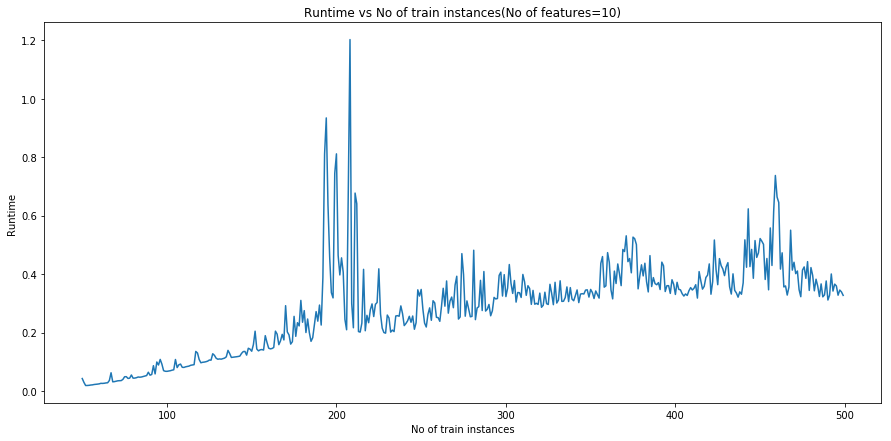

In [147]:
plt.plot(range(50,n_sam),t)
plt.xlabel('No of train instances')
plt.ylabel('Runtime')
plt.title('Runtime vs No of train instances(No of features=10)')
plt.show()

In [148]:
tf=[]
for i in range(n_feat):
    ts=time.time()
    y_pred=KNN_predict(train_X[:200,:i], train_Y[:200], test_X[:200,:i],2)
    te=time.time()
    tf.append(te-ts)

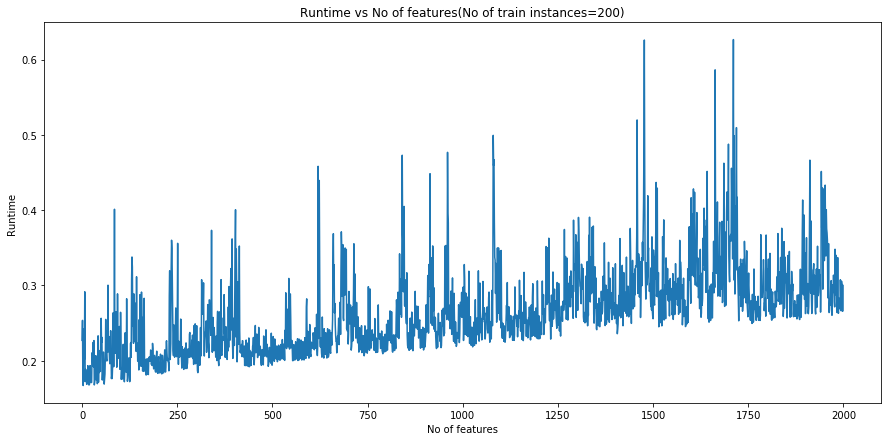

In [149]:
plt.plot(range(n_feat),tf)
plt.xlabel('No of features')
plt.ylabel('Runtime')
plt.title('Runtime vs No of features(No of train instances=200)')
plt.show()

# Q2

In [ ]:
fp = 'Real estate valuation data set.xlsx'
reg_data=pd.read_excel(fp)
reg_data=reg_data[reg_data.columns[1:]]
X=np.array(reg_data[reg_data.columns[:-1]])
Y=np.array(reg_data[reg_data.columns[-1]])

train_X, test_X, train_Y, test_Y=train_test_split(X,Y,random_state=12)

In [7]:
def k_fold(data,k):
    shuffle=data.sample(frac=1).reset_index(drop=1)
    i=int(len(shuffle)/k)
    cvs=np.array([None]*k)
    for j in range(k):
        cvs[j]=shuffle[i*j:i*(j+1)]
    return cvs

# Q2(a)

In [8]:
from IPython.display import clear_output

cvs=k_fold(reg_data,5)
k=len(cvs)
va={}
x=np.array(range(k))

for i in range(k):
    [train,val,test]=[pd.DataFrame(np.concatenate(cvs[x[0:k-2]]),columns=reg_data.columns).reset_index(drop=1),pd.DataFrame(cvs[x[k-2]]).reset_index(drop=1),pd.DataFrame(cvs[x[k-1]]).reset_index(drop=1)]
    rss_min=math.inf
    rss_tr=0
    rss_te=0
    k_op=0
    k_info={}
    [train_X,train_Y]=[np.array(train[train.columns[:-1]]),np.array(train[train.columns[-1]])]
    [val_X,val_Y]=[np.array(val[val.columns[:-1]]),np.array(val[val.columns[-1]])]
    [test_X,test_Y]=[np.array(test[test.columns[:-1]]),np.array(test[test.columns[-1]])]
    
    for K in range(1,100):
        knn=KNeighborsRegressor(n_neighbors=K)
        knn.fit(train_X, train_Y)
        y_pred_v=knn.predict(val_X)
#         y_pred_v=KNN_predict(train_X, train_Y, val_X, K, type='regression')
        rss_v=math.sqrt(mean_squared_error(val_Y,y_pred_v))

        if rss_min>rss_v:
            rss_min=rss_v
            k_op=K
            y_pred_tr=knn.predict(train_X)#KNN_predict(train_X, train_Y, train_X, K, type='regression')
            y_pred_te=knn.predict(test_X)#KNN_predict(train_X, train_Y, test_X, K, type='regression')
            rss_tr=math.sqrt(mean_squared_error(train_Y,y_pred_tr))
            rss_te=math.sqrt(mean_squared_error(test_Y,y_pred_te))
        k_info[(i,K)]=rss_min
    
    va[i+1]=[k_op,[rss_tr,rss_min,rss_te]]
    x=np.roll(x,1)

clear_output(wait=True)
for pr in va.keys():
    print('Fold No ',pr)
    print('Optimal K: ',va[pr][0])
    print('Train Error: ',va[pr][1][0])
    print('Validation Error: ',va[pr][1][1])
    print('Test Error: ',va[pr][1][2])

Fold No  1
Optimal K:  11
Train Error:  8.153174052330494
Validation Error:  8.670054195335254
Test Error:  8.28499571521974
Fold No  2
Optimal K:  57
Train Error:  9.375371810430476
Validation Error:  7.374646350415736
Test Error:  9.28469510000683
Fold No  3
Optimal K:  2
Train Error:  5.0212950990302
Validation Error:  6.730217171141782
Test Error:  7.654063961187626
Fold No  4
Optimal K:  3
Train Error:  5.732683362665808
Validation Error:  9.6457736086581
Test Error:  8.417327109240595
Fold No  5
Optimal K:  4
Train Error:  6.447514607491878
Validation Error:  7.707828812318032
Test Error:  10.142209854450227


# Q2(b)

In [9]:
fp = 'Real estate valuation data set.xlsx'
reg_data=pd.read_excel(fp)
reg_data=reg_data[reg_data.columns[1:]]
X=np.array(reg_data[reg_data.columns[:-1]])
Y=np.array(reg_data[reg_data.columns[-1]])

X=normalize(X, copy=False)

train_X, test_X, train_Y, test_Y=train_test_split(X,Y,random_state=12)

In [10]:
from IPython.display import clear_output

cvs=k_fold(reg_data,5)
k=len(cvs)
va={}
x=np.array(range(k))

for i in range(k):
    [train,val,test]=[pd.DataFrame(np.concatenate(cvs[x[0:k-2]]),columns=reg_data.columns).reset_index(drop=1),pd.DataFrame(cvs[x[k-2]]).reset_index(drop=1),pd.DataFrame(cvs[x[k-1]]).reset_index(drop=1)]
    rss_min=math.inf
    rss_tr=0
    rss_te=0
    k_op=0
    k_info={}
    [train_X,train_Y]=[np.array(train[train.columns[:-1]]),np.array(train[train.columns[-1]])]
    [val_X,val_Y]=[np.array(val[val.columns[:-1]]),np.array(val[val.columns[-1]])]
    [test_X,test_Y]=[np.array(test[test.columns[:-1]]),np.array(test[test.columns[-1]])]
    
    for K in range(1,100):
        knn=KNeighborsRegressor(n_neighbors=K)
        knn.fit(train_X, train_Y)
        y_pred_v=knn.predict(val_X)
#         y_pred_v=KNN_predict(train_X, train_Y, val_X, K, type='regression')
        rss_v=math.sqrt(mean_squared_error(val_Y,y_pred_v))

        if rss_min>rss_v:
            rss_min=rss_v
            k_op=K
            y_pred_tr=knn.predict(train_X)#KNN_predict(train_X, train_Y, train_X, K, type='regression')
            y_pred_te=knn.predict(test_X)#KNN_predict(train_X, train_Y, test_X, K, type='regression')
            rss_tr=math.sqrt(mean_squared_error(train_Y,y_pred_tr))
            rss_te=math.sqrt(mean_squared_error(test_Y,y_pred_te))
        k_info[(i,K)]=rss_min
    
    va[i+1]=[k_op,[rss_tr,rss_min,rss_te]]
    x=np.roll(x,1)

clear_output(wait=True)
for pr in va.keys():
    print('Fold No ',pr)
    print('Optimal K: ',va[pr][0])
    print('Train Error: ',va[pr][1][0])
    print('Validation Error: ',va[pr][1][1])
    print('Test Error: ',va[pr][1][2])

Fold No  1
Optimal K:  9
Train Error:  8.483510435689702
Validation Error:  7.170728665449276
Test Error:  7.567780839538799
Fold No  2
Optimal K:  38
Train Error:  8.659505345571938
Validation Error:  9.940913150881055
Test Error:  7.641982208046778
Fold No  3
Optimal K:  4
Train Error:  6.685827330517588
Validation Error:  5.86525008303869
Test Error:  9.549679154360083
Fold No  4
Optimal K:  9
Train Error:  7.556026607347043
Validation Error:  10.665318060636439
Test Error:  6.1992480190104065
Fold No  5
Optimal K:  7
Train Error:  7.10789171315517
Validation Error:  7.636356120128864
Test Error:  10.776534617278031


# Q2(c)

In [138]:
fp = 'Real estate valuation data set.xlsx'
reg_data=pd.read_excel(fp)
reg_data=reg_data[reg_data.columns[1:]]
X=np.array(reg_data[reg_data.columns[:-1]])
Y=np.array(reg_data[reg_data.columns[-1]])

# X=normalize(X, copy=False)

train_X, test_X, train_Y, test_Y=train_test_split(X,Y,random_state=1,test_size=0.2)

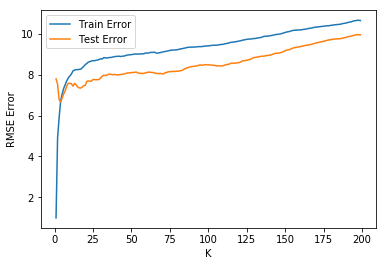

In [61]:
train_err=[]
test_err=[]
for k in range(1,200):
    knn=KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_X, train_Y)
    y_pred_tr=knn.predict(train_X)
    y_pred_te=knn.predict(test_X)
    train_err.append(math.sqrt(mean_squared_error(train_Y,y_pred_tr)))
    test_err.append(math.sqrt(mean_squared_error(test_Y,y_pred_te)))
plt.plot(range(1,200),train_err)
plt.plot(range(1,200),test_err)
plt.legend(['Train Error', 'Test Error'])
plt.xlabel('K')
plt.ylabel('RMSE Error')
plt.show()

In [139]:
knn=KNeighborsRegressor(n_neighbors=1)
knn.fit(train_X, train_Y)
y_pred=knn.predict(test_X)
home_err=[np.argmax(abs(y_pred-test_Y)),max(abs(y_pred-test_Y))]

for i in range(len(reg_data.columns[:-1])):
    print(str(reg_data.columns[i])+" : "+str(test_X[home_err[0]][i]))
print("RMSE error of the home : ",home_err[1])

X1 transaction date : 2013.4166667
X2 house age : 40.1
X3 distance to the nearest MRT station : 123.7429
X4 number of convenience stores : 8.0
X5 latitude : 24.97635
X6 longitude : 121.54329
RMSE error of the home :  23.400000000000006


/Users/girish/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


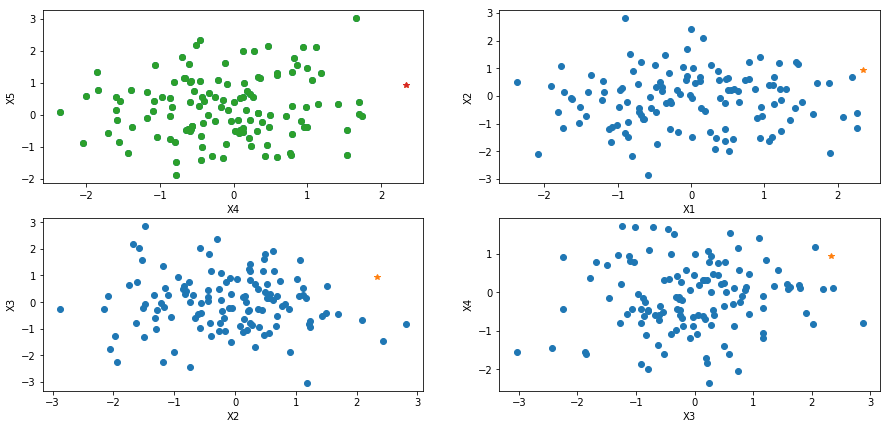

In [151]:
# col=['red','green','blue']
# col_sq=['']*len(test_Y)
# for i in range(len(test_Y)):
#     col_sq[i]=col[int(test_Y[i])]
plt.subplot(2,2,1)
plt.plot(test_X[:,4],test_X[:,5],'o')
plt.plot(test_X[home_err[0],0],test_X[home_err[0],1],'*')
plt.xlabel('X4')
plt.ylabel('X5')

plt.subplot(2,2,2)
plt.plot(test_X[:,1],test_X[:,2],'o')
plt.plot(test_X[home_err[0],0],test_X[home_err[0],1],'*')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(2,2,3)
plt.plot(test_X[:,2],test_X[:,3],'o')
plt.plot(test_X[home_err[0],0],test_X[home_err[0],1],'*')
plt.xlabel('X2')
plt.ylabel('X3')

plt.subplot(2,2,4)
plt.plot(test_X[:,3],test_X[:,4],'o')
plt.plot(test_X[home_err[0],0],test_X[home_err[0],1],'*')
plt.xlabel('X3')
plt.ylabel('X4')

plt.show()

It can be seen from the above plots that the outlier is very far from all the samples. Thus the RMSE is high for it.

# Q3

In [105]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from scipy.spatial import voronoi_plot_2d, Voronoi

iris=datasets.load_iris()
irispd=pd.DataFrame(np.c_[iris.data[:,:2],iris.target],columns=iris.feature_names[:2]+['class'])
X=np.array(irispd[irispd.columns[:-1]])
Y=np.array(irispd[irispd.columns[-1]])

train_X, test_X, train_Y, test_Y=train_test_split(X,Y,random_state=12)

In [106]:
col=['red','green','blue']
col_sq=['']*150
for i in range(len(Y)):
    col_sq[i]=col[int(Y[i])]

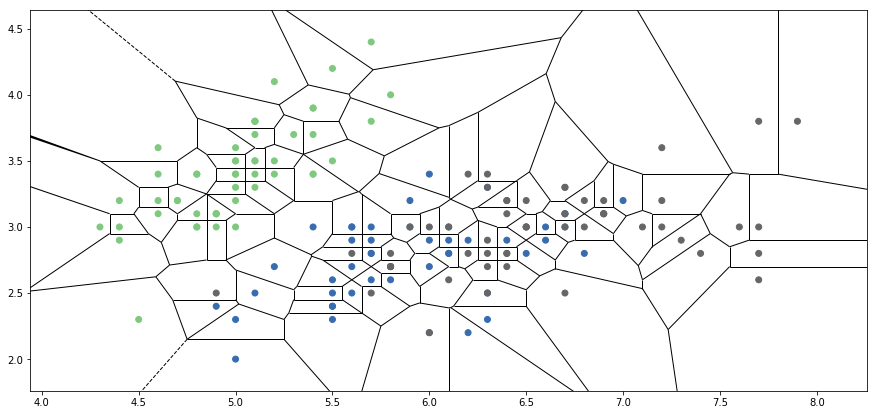

In [46]:
vor=Voronoi(X)
plt.rcParams['figure.figsize']=[15,7]
voronoi_plot_2d(vor,show_vertices=False,show_points=False)
plt.scatter(X[:,0],X[:,1],c=col_sq)
# plt.scatter(X[Y==0,0],X[Y==0,1])
# plt.scatter(X[Y==1,0],X[Y==1,1])
# plt.scatter(X[Y==2,0],X[Y==2,1])
# plt.legend(['','','0','1','2'])
plt.show()

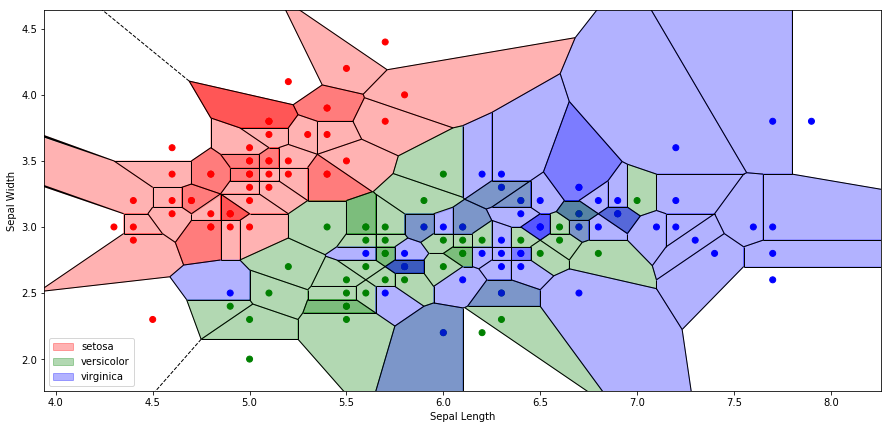

In [119]:
norm = mpl.colors.Normalize(vmin=0, vmax=2, clip=True)
# mapper = cm.ScalarMappable(norm=norm, cmap=cm.)
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1)
for r in range(len(vor.point_region)):
    region = vor.regions[vor.point_region[r]]
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), color=col[int(Y[r])], alpha=0.3)
p = plt.scatter(X[:,0],X[:,1],c=col_sq, cmap=matplotlib.colors.ListedColormap(col))
plt.legend(iris.target_names)
ax = plt.gca()
legend = ax.get_legend()
legend.legendHandles[0].set_color(col[0])
legend.legendHandles[1].set_color(col[1])
legend.legendHandles[2].set_color(col[2])
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()

It can be infered from the voronoi diagram that 1-NN overfits the training data. The outliers form a cluster inside a bigger cluster of a different class